In [1]:
%matplotlib inline
import sys
sys.path.append("..") # Adds the module to path

# deeptrack.augmentations

This example introduces the module deeptrack.augmentations.

## 1. What is an augmentation?



Augmentations are instances of the abstract class `Feature` and serve to decrease the average simulation time by altering the input image several times before performing additional expensive computation. For example, `FlipDiagonal` is an augmentation that returns both the input image and the transposed image before recomputing the input.

All augmentations take a parent feature as their first input, and two keyword arguments, `load_size` and `updates_per_reload`. When an augmentation is initialized, it resolves `load_size` number of images from the parent, and stores them. When an augmentation in updated, it loads one of these images, sampled randomly. When the augmentation has been resolved `updated_per_resolve` number of times, it resolves a new set of images from its parent feature. When the augmentation is resolved, it alters the loaded image using the method `.get()`.  

Many augmentations fundamentally change the appearance of images. Augmentations may optionally define a method `update_properties` to ensure that properties are still representative. This function can also optionally be passed as a keyword argument when initializing the augmentation feature.

## 2. Example of an augmentation

Below is the implementation of the feature `FlipLR`. The constructor calls the constructor of `Augmentation` with `load_size=1` and `updates_per_reload=2`. This means it will load one image, apply the transformation twice, then load a new image.

`update_properties` inverts the second value of the property `position`.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from deeptrack.augmentations import Augmentation


# Implementation of abstract class Augmentation
# which mirrors the input left to right

class FlipLR(Augmentation):
    """Flips images left-right.

    Updates all properties called "position" to flip the second index.
    """

    def __init__(self, *args, **kwargs):
        super().__init__(*args, load_size=1, updates_per_reload=2, **kwargs)

    def get(self, image, number_of_updates, **kwargs):
        if number_of_updates % 2:
            image = np.fliplr(image)
        return image

    def update_properties(self, image, number_of_updates, **kwargs):
        if number_of_updates % 2:
            for prop in image.properties:
                if "position" in prop:
                    position = prop["position"]
                    new_position = (
                        position[0],
                        image.shape[1] - position[1] - 1,
                        *position[2:],
                    )
                    prop["position"] = new_position

## 3. Augmentations in use

Here we show augmentations in use. We define dummy feature which represent some potentially very slow feature or combination of features.

In [3]:
from deeptrack.features import Feature 

class DummyFeature(Feature):
    __distributed__ = False
    def get(self, image, **kwargs):
        print("I am a very slow feature...")
        output = np.zeros((2, 2, 1))
        output[0, 0] = 1
        return output
        
        
slow_feature = DummyFeature()

augmented_feature = FlipLR(slow_feature)

Note that despite resolving two images, the method `get` of `DummyFeature` is only called once.

I am a very slow feature...


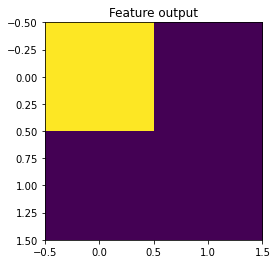

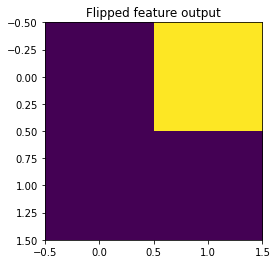

In [4]:

augmented_feature.update()
output_1 = augmented_feature.resolve()

augmented_feature.update()
output_2 = augmented_feature.resolve()

plt.imshow(output_1[..., 0])
plt.title("Feature output")
plt.show()

plt.imshow(output_2[..., 0])
plt.title("Flipped feature output")
plt.show()

## 4. Augmenting multiple features equally

It is not unusual to wasnt to ensure several images are augmented the same. A common example is when creating an image-label pair using two different features, or the same feature resolved with different arguments. In the this case you can pass a list of features to the augmentation feature. The features will be resolved sequentially and create a list of images.

Here we show how two identical features are augmented equally.

In [5]:
slow_feature_1 = DummyFeature()
slow_feature_2 = DummyFeature()

augmented_features = FlipLR([slow_feature_1, slow_feature_2])

I am a very slow feature...
I am a very slow feature...


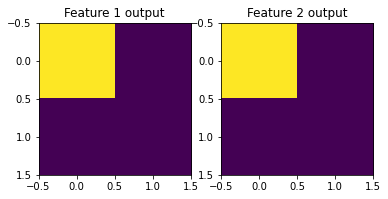

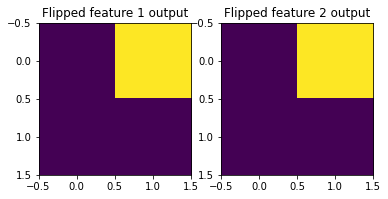

In [6]:
augmented_features.update()
output_1 = augmented_features.resolve()



plt.subplot(1, 2, 1)
plt.imshow(output_1[0][..., 0])
plt.title("Feature 1 output")
plt.subplot(1, 2, 2)
plt.imshow(output_1[1][..., 0])
plt.title("Feature 2 output")
plt.show()


augmented_features.update()
output_2 = augmented_features.resolve()

plt.subplot(1, 2, 1)
plt.imshow(output_2[0][..., 0])
plt.title("Flipped feature 1 output")
plt.subplot(1, 2, 2)
plt.imshow(output_2[1][..., 0])
plt.title("Flipped feature 2 output")
plt.show()